# Variational Message Passing for Estimation

ForneyLab comes with support for variational message passing (VMP) (Dauwels, 2007). In this demo we illustrate VMP by estimating the mean and precision (inverse variance) of i.i.d. samples drawn from a Gaussian distribution. The model is easily defined as 
\begin{align*}
    y_i \sim \mathcal{N}(m, w^{-1})
\end{align*}
The factor graph below shows one section of our generative model.

```
-------------> = ---> (w)
               | 
---> = --------|----> (m)
     |         |
     --->[N]<---
          | 
        (y_i)
```

Variational inference approximates the posterior over $m$ and $w$ by a recognition distribution. We minimize the KL divergence between the exact posterior and the recognition distribution by variational message passing.

In [1]:
# Toy dataset
n = 5

m_data = 3.0
w_data = 4.0
y_data = sqrt(1/w_data)*randn(n) + m_data;

# Build

In [2]:
using(ForneyLab)

g = FactorGraph()

# Priors
@RV m ~ GaussianMeanVariance(constant(0.0), constant(100.0), id=:m)
@RV w ~ Gamma(constant(0.01), constant(0.01), id=:w)

# Observarion model
for i = 1:n
    @RV y_i ~ GaussianMeanPrecision(m, w, id=:y_*i)
    placeholder(y_i, :y, index=i)
end

# Schedule

With the model defined, we can now specify the recognition factorization, generate a schedule for each recognition factor. The `RecognitionFactor()` constructor accepts a (collection of) variable(s). These variables will become part of a single subgraph. This allows for defining structured factorizations as well. All variables that are deterministically linked to the argument variables (e.g. through a `+` or `=` relation), automatically become part of the subgraph as well.

We can inspect a subgraph with the `draw()` function, where external edges are dashed. After defining a recognition factor it is always wise to inspect if the factorgraph for the subgraph corresponds with your expectations.

In [3]:
# Specify recognition factorization
q = RecognitionFactorization(m, w, ids=[:M, :W])

# Inspect the subgraph for m
ForneyLab.draw(q.recognition_factors[:M])

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6477911933338509965 -->
 6477911933338509965 
 
 𝒩 
 y_2 
 
<!-- 5458812970720951023 -->
 5458812970720951023 
 
 = 
 equ_m_1 
 
<!-- 12515225901541877746 -->
 12515225901541877746 
 
 𝒩 
 y_1 
 
<!-- 5458812970720951023--12515225901541877746 -->
 5458812970720951023--12515225901541877746 
 
 2 m 
 
<!-- 1374405363506259127 -->
 1374405363506259127 
 
 𝒩 
 m 
 
<!-- 5458812970720951023--1374405363506259127 -->
 5458812970720951023--1374405363506259127 
 
 1 out 
 
<!-- 17086797884014673992 -->
 17086797884014673992 
 
 = 
 equ_m_4 
 
<!-- 8212833677508763390 -->
 8212833677508763390 
 
 = 
 equ_m_3 
 
<!-- 17086797884014673992--8212833677508763390 -->
 17086797884014673992--8212833677508763390 
 
 3 3 
 
<!-- 2133588164777520576 -->
 2133588164777520576 
 
 𝒩 
 y_4 
 
<!-- 17086797884014673992--2133588164777520576 -->
 17086797884014673992--2133588164777520576 
 
 2 m 
 
<!-- 4669346886265598290 -->
 4669346886265598290 
 
 𝒩 
 y_5 
 
<!-- 17086797884014673992--4669346886265598290 -->
 17086797884014673992--4669346886265598290 
 
 2 m 
 
<!-- 9809459634209520380 -->
 9809459634209520380 
 
 𝒩 
 y_3 
 
<!-- 8212833677508763390--9809459634209520380 -->
 8212833677508763390--9809459634209520380 
 
 2 m 
 
<!-- 1753741810993215350 -->
 1753741810993215350 
 
 = 
 equ_m_2 
 
<!-- 8212833677508763390--1753741810993215350 -->
 8212833677508763390--1753741810993215350 
 
 3 3 
 
<!-- 1753741810993215350--6477911933338509965 -->
 1753741810993215350--6477911933338509965 
 
 2 m 
 
<!-- 1753741810993215350--5458812970720951023 -->
 1753741810993215350--5458812970720951023 
 
 3 3 
 
<!-- 12817995223179988818 -->
 12817995223179988818 
 
<!-- 1374405363506259127--12817995223179988818 -->
 1374405363506259127--12817995223179988818 
 
 1 out 
 3 v 
 
<!-- 7332767711660880127 -->
 7332767711660880127 
 
<!-- 1374405363506259127--7332767711660880127 -->
 1374405363506259127--7332767711660880127 
 
 1 out 
 2 m 
 
<!-- 13246672229209413753 -->
 13246672229209413753 
 
<!-- 13246672229209413753--12515225901541877746 -->
 13246672229209413753--12515225901541877746 
 
 1 out 
 1 out 
 
<!-- 13498188565770239538 -->
 13498188565770239538 
 
<!-- 13498188565770239538--6477911933338509965 -->
 13498188565770239538--6477911933338509965 
 
 3 w 
 1 1 
 
<!-- 5210326452279457643 -->
 5210326452279457643 
 
<!-- 5210326452279457643--9809459634209520380 -->
 5210326452279457643--9809459634209520380 
 
 3 w 
 1 1 
 
<!-- 3181334099791984516 -->
 3181334099791984516 
 
<!-- 3181334099791984516--2133588164777520576 -->
 3181334099791984516--2133588164777520576 
 
 1 out 
 1 out 
 
<!-- 2980609266976447800 -->
 2980609266976447800 
 
<!-- 2980609266976447800--9809459634209520380 -->
 2980609266976447800--9809459634209520380 
 
 1 out 
 1 out 
 
<!-- 2405816978970021080 -->
 2405816978970021080 
 
<!-- 2405816978970021080--2133588164777520576 -->
 2405816978970021080--2133588164777520576 
 
 3 w 
 1 1 
 
<!-- 2405816978970021080--4669346886265598290 -->
 2405816978970021080--4669346886265598290 
 
 3 w 
 3 3 
 
<!-- 14501895214695006864 -->
 14501895214695006864 
 
<!-- 14501895214695006864--12515225901541877746 -->
 14501895214695006864--12515225901541877746 
 
 3 w 
 2 2 
 
<!-- 12572543036914474577 -->
 12572543036914474577 
 
<!-- 12572543036914474577--6477911933338509965 -->
 12572543036914474577--6477911933338509965 
 
 1 out 
 1 out 
 
<!-- 15612649670738314605 -->
 15612649670738314605 
 
<!-- 15612649670738314605--4669346886265598290 -->
 15612649670738314605--4669346886265598290 
 
 1 out 
 1 out

In [4]:
# Inspect the subgraph for m
ForneyLab.draw(q.recognition_factors[:W])

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6477911933338509965 -->
 6477911933338509965 
 
 𝒩 
 y_2 
 
<!-- 79856435531441051 -->
 79856435531441051 
 
 Gam 
 w 
 
<!-- 12905803682089355834 -->
 12905803682089355834 
 
<!-- 79856435531441051--12905803682089355834 -->
 79856435531441051--12905803682089355834 
 
 1 out 
 3 b 
 
<!-- 10832602437401078434 -->
 10832602437401078434 
 
<!-- 79856435531441051--10832602437401078434 -->
 79856435531441051--10832602437401078434 
 
 1 out 
 2 a 
 
<!-- 13498188565770239538 -->
 13498188565770239538 
 
 = 
 equ_w_2 
 
<!-- 13498188565770239538--6477911933338509965 -->
 13498188565770239538--6477911933338509965 
 
 3 w 
 
<!-- 14501895214695006864 -->
 14501895214695006864 
 
 = 
 equ_w_1 
 
<!-- 13498188565770239538--14501895214695006864 -->
 13498188565770239538--14501895214695006864 
 
 3 3 
 
<!-- 9809459634209520380 -->
 9809459634209520380 
 
 𝒩 
 y_3 
 
<!-- 2133588164777520576 -->
 2133588164777520576 
 
 𝒩 
 y_4 
 
<!-- 14501895214695006864--79856435531441051 -->
 14501895214695006864--79856435531441051 
 
 1 out 
 
<!-- 12515225901541877746 -->
 12515225901541877746 
 
 𝒩 
 y_1 
 
<!-- 14501895214695006864--12515225901541877746 -->
 14501895214695006864--12515225901541877746 
 
 3 w 
 
<!-- 2405816978970021080 -->
 2405816978970021080 
 
 = 
 equ_w_4 
 
<!-- 2405816978970021080--2133588164777520576 -->
 2405816978970021080--2133588164777520576 
 
 3 w 
 
<!-- 5210326452279457643 -->
 5210326452279457643 
 
 = 
 equ_w_3 
 
<!-- 2405816978970021080--5210326452279457643 -->
 2405816978970021080--5210326452279457643 
 
 3 3 
 
<!-- 4669346886265598290 -->
 4669346886265598290 
 
 𝒩 
 y_5 
 
<!-- 2405816978970021080--4669346886265598290 -->
 2405816978970021080--4669346886265598290 
 
 3 w 
 
<!-- 5210326452279457643--13498188565770239538 -->
 5210326452279457643--13498188565770239538 
 
 3 3 
 
<!-- 5210326452279457643--9809459634209520380 -->
 5210326452279457643--9809459634209520380 
 
 3 w 
 
<!-- 5458812970720951023 -->
 5458812970720951023 
 
<!-- 5458812970720951023--12515225901541877746 -->
 5458812970720951023--12515225901541877746 
 
 2 m 
 2 2 
 
<!-- 17086797884014673992 -->
 17086797884014673992 
 
<!-- 17086797884014673992--2133588164777520576 -->
 17086797884014673992--2133588164777520576 
 
 2 m 
 1 1 
 
<!-- 17086797884014673992--4669346886265598290 -->
 17086797884014673992--4669346886265598290 
 
 2 m 
 3 3 
 
<!-- 13246672229209413753 -->
 13246672229209413753 
 
<!-- 13246672229209413753--12515225901541877746 -->
 13246672229209413753--12515225901541877746 
 
 1 out 
 1 out 
 
<!-- 3181334099791984516 -->
 3181334099791984516 
 
<!-- 3181334099791984516--2133588164777520576 -->
 3181334099791984516--2133588164777520576 
 
 1 out 
 1 out 
 
<!-- 2980609266976447800 -->
 2980609266976447800 
 
<!-- 2980609266976447800--9809459634209520380 -->
 2980609266976447800--9809459634209520380 
 
 1 out 
 1 out 
 
<!-- 12572543036914474577 -->
 12572543036914474577 
 
<!-- 12572543036914474577--6477911933338509965 -->
 12572543036914474577--6477911933338509965 
 
 1 out 
 1 out 
 
<!-- 15612649670738314605 -->
 15612649670738314605 
 
<!-- 15612649670738314605--4669346886265598290 -->
 15612649670738314605--4669346886265598290 
 
 1 out 
 1 out 
 
<!-- 8212833677508763390 -->
 8212833677508763390 
 
<!-- 8212833677508763390--9809459634209520380 -->
 8212833677508763390--9809459634209520380 
 
 2 m 
 1 1 
 
<!-- 1753741810993215350 -->
 1753741810993215350 
 
<!-- 1753741810993215350--6477911933338509965 -->
 1753741810993215350--6477911933338509965 
 
 2 m 
 1 1

With the recognition factorization defined, we are now prepared to derive our inference algorithm. With VMP, each recognition factor requires a separate inference algorithm. The `name` argument allows us to pass a unique identifier.

In [5]:
# Generate algorithms
algo = variationalAlgorithm(q)

# Inspect the algorithm code
println(algo)

begin

function stepM!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(10))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=0.0), ProbabilityDistribution(Univariate, PointMass, m=100.0))
messages[2] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][4]), nothing, marginals[:w])
messages[3] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][5]), nothing, marginals[:w])
messages[4] = ruleSPEqualityGaussian(messages[2], nothing, messages[3])
messages[5] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][3]), nothing, marginals[:w])
messages[6] = ruleSPEqualityGaussian(messages[5], nothing, messages[4])
messages[7] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][2]), nothing, marginals[:w])
messages[8] = ruleSPEqualityGaussian(messages[7], nothing, messag

Note that the algorithm of `stepM!()` requires the marginal from `marginals[:w]`. Because VMP is an iterative algorithm, it requires that we initialize the marginals before we start the estimation. The `marginals` argument allows us to pass an initial dictionary of marginals. Upon execution, this dictionary is updated in-place with the newly computed outcomes. Additionally, we can also automatically generate code that evaluates the free energy, with `freeEnergyAlgorithm()`. This yields a model-specific `freeEnergy()` function that accepts the `data` and `marginals` dictionary. 

The free energy can be used to check for algorithm convergence or for model comparison.

In [6]:
algo_F = freeEnergyAlgorithm(q)

println(algo_F)

function freeEnergy(data::Dict, marginals::Dict)

F = 0.0

F += averageEnergy(ForneyLab.GaussianMeanVariance, marginals[:m], ProbabilityDistribution(Univariate, PointMass, m=0.0), ProbabilityDistribution(Univariate, PointMass, m=100.0))
F += averageEnergy(ForneyLab.Gamma, marginals[:w], ProbabilityDistribution(Univariate, PointMass, m=0.01), ProbabilityDistribution(Univariate, PointMass, m=0.01))
F += averageEnergy(ForneyLab.GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][1]), marginals[:m], marginals[:w])
F += averageEnergy(ForneyLab.GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][2]), marginals[:m], marginals[:w])
F += averageEnergy(ForneyLab.GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][3]), marginals[:m], marginals[:w])
F += averageEnergy(ForneyLab.GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][4]), marginals[:m], marginals[:w])
F += averageEnergy(F

# Infer

In [7]:
# Load algorithms
eval(parse(algo))
eval(parse(algo_F))
;

As mentioned before, we need to initialize the `marginals` dictionary. After initialization, we iteratively step through the algorithm functions and evaluate the free energy after each iteration.

In [8]:
data = Dict(:y => y_data)

# Initial recognition distributions
marginals = Dict(:m => vague(Gaussian),
                 :w => vague(Gamma))

n_its = 2*n
F = Vector{Float64}(n_its) # Initialize vector for storing Free energy
m_est = Vector{Float64}(n_its)
w_est = Vector{Float64}(n_its)
for i = 1:n_its
    stepM!(data, marginals)
    stepW!(data, marginals)
    
    # Store free energy
    F[i] = freeEnergy(data, marginals)
    
    # Store estimates
    m_est[i] = mean(marginals[:m])
    w_est[i] = mean(marginals[:w])
end
;

# Results

After estimation, we can plot the estimates and the free energy over time, and read out the final estimate.

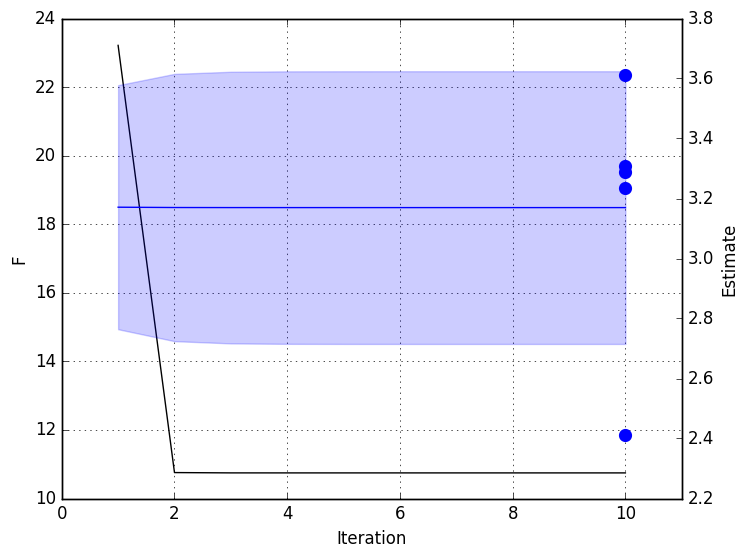

In [9]:
using PyPlot

# Plot free energy to check for convergence
plot(1:n_its, F, color="black")
grid("on")
xlabel("Iteration")
ylabel("F")

# Plot estimated distribution
PyPlot.plt[:twinx]()
plot(1:n_its, m_est, color="blue")
fill_between(1:n_its, m_est-sqrt.(1.0./w_est), m_est+sqrt.(1.0./w_est), color="blue", alpha=0.2)
ylabel("Estimate")

# Plot samples
scatter(n_its*ones(n), y_data, color="blue", linewidth=5)

xlim(0.0, n_its+1)
;

In [10]:
# Inspect the results
println("\n----- Estimates after $(n_its) VMP updates -----")
println("Mean estimate: $(round(mean(marginals[:m]),2)), with variance $(round(var(marginals[:m]),2))")
println("Precision estimate: $(round(mean(marginals[:w]),2)), with variance $(round(var(marginals[:w]),2))")


----- Estimates after 10 VMP updates -----
Mean estimate: 3.17, with variance 0.04
Precision estimate: 4.84, with variance 9.33
